In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    plot_thresh_to_acc, age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps
)

In [3]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error

from decode_tueg import plot_heatmaps, plot_age_gap_hist, plot_thresh_to_acc, plot_learning_curves

/tmp/ipykernel_4652/3859480325.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
df = pd.read_csv('/home/jovyan/220824_5fcv_huber.csv', index_col=0)

In [ ]:
df

,index,y_pred,y_true,pathological,exp,subset,split,fold
0,0,47.562190,55.0,False,220824144139015381,normal,valid,3
1,1,63.435150,70.0,False,220824144139015381,normal,valid,3
2,2,40.898357,39.0,False,220824144139015381,normal,valid,3
3,3,58.216160,59.0,False,220824144139015381,normal,valid,3
4,4,26.794992,24.0,False,220824144139015381,normal,valid,3
...,...,...,...,...,...,...,...,...
26925,1051,48.591175,38.0,True,220824144055632350,abnormal,train,0
26926,1052,44.417076,85.0,True,220824144055632350,abnormal,train,0
26927,1053,40.556297,31.0,True,220824144055632350,abnormal,train,0
26928,1054,46.593445,40.0,True,220824144055632350,abnormal,train,0


In [ ]:
# only look at valid set
df = df[df.split == 'valid']

In [ ]:
df.shape

(5386, 8)

In [ ]:
mean_absolute_error(df.y_true, df.y_pred)

9.395337378707762

In [ ]:
mean_absolute_error(df[df.pathological].y_true, df[df.pathological].y_pred)

11.63164204531722

In [ ]:
mean_absolute_error(df[~df.pathological].y_true, df[~df.pathological].y_pred)

7.232541631015341

In [ ]:
bin_size = 2
max_age = 100
hist_max_count = 450

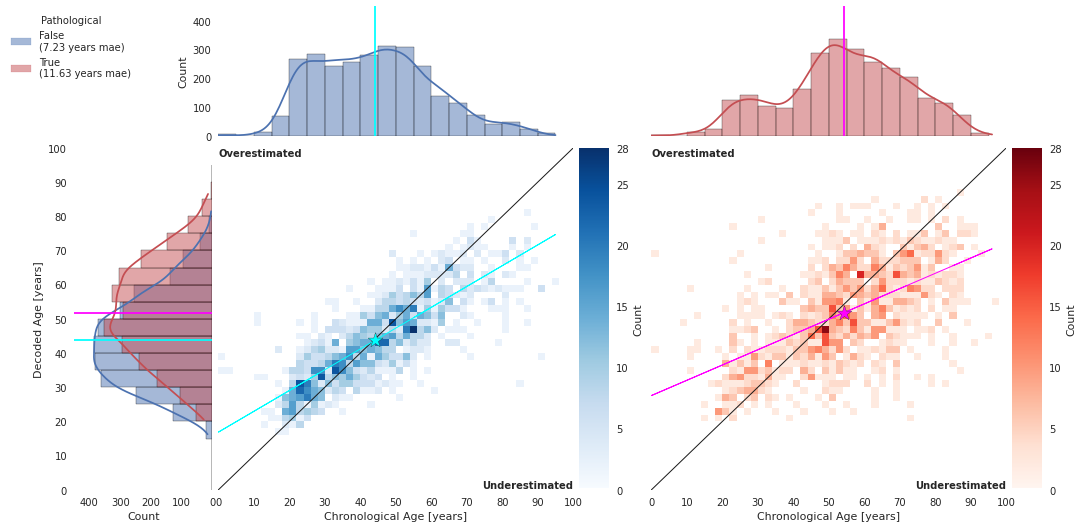

In [14]:
fig = plot_heatmaps(df, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

In [45]:
ax = plot_age_gap_hist(df)
ax.get_figure().tight_layout()
ax.set_title('')
# ax.get_figure().savefig('/home/jovyan/age_gap.png', dpi=300, bbox_inches='tight')

NameError: name 'df' is not defined

In [16]:
# plot learning curves

In [25]:
histories = [pd.read_csv(f'/home/jovyan/new_full_runs/{exp}/history.csv', index_col=0) for exp in df.exp.unique()]

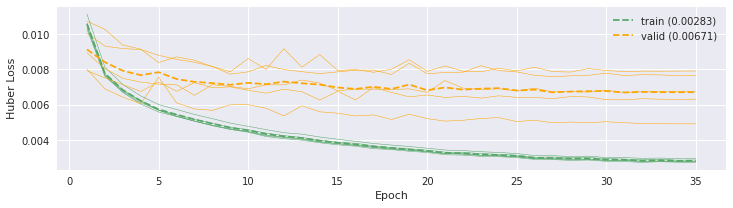

In [27]:
ax = plot_learning_curves(histories, 'Huber Loss')

In [82]:
# plot age gap proxy result

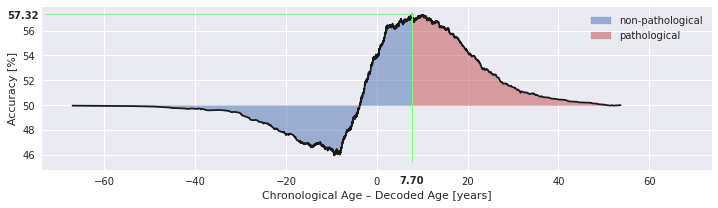

In [83]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax = plot_thresh_to_acc(df, ax=ax)
# ax.set_ylim(45,58)
# ax.set_xlim(-70,70)
# fig.savefig('/home/jovyan/proxy.png', bbox_inches='tight', dpi=300)

In [84]:
# plot longitudinal transition decoding results

In [ ]:
bin_size = 2
max_age = 100

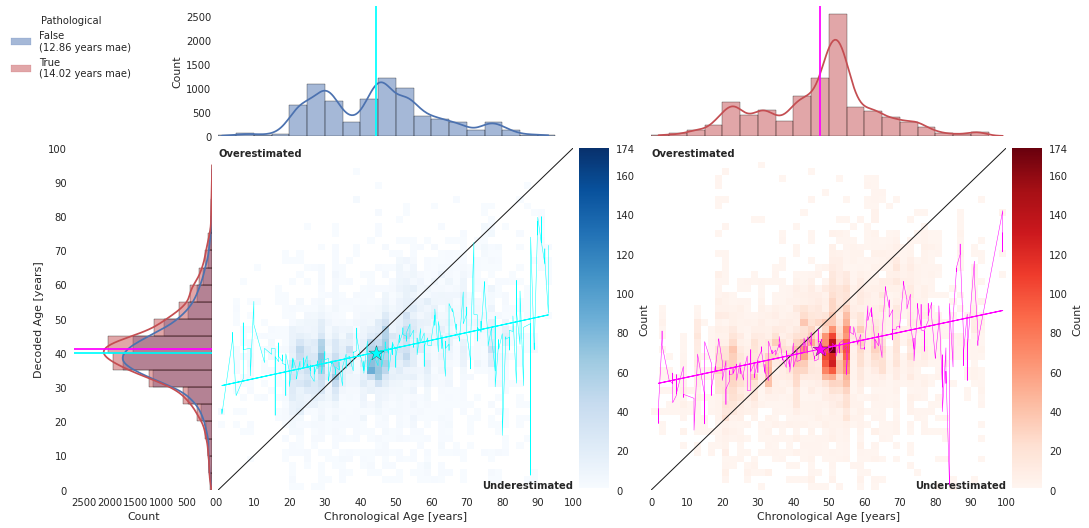

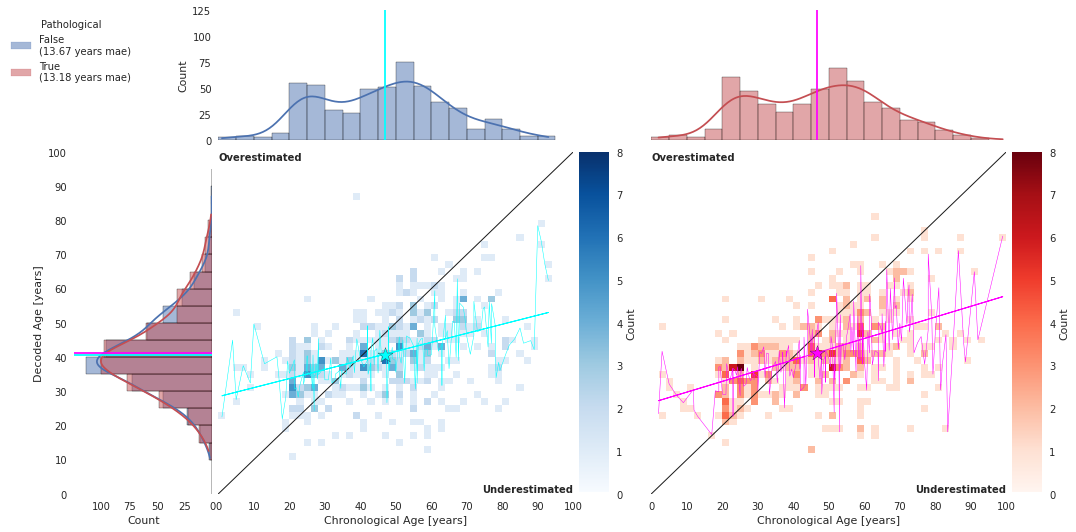

In [ ]:
for subject_wise in [False, True]:
    hist_max_count = 2700 if not subject_wise else 125

    # fdescribe i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
    longitudinal = 'transition'
    df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
    # --- hack
    with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
        ds = pickle.load(f)
    df['subject'] = 5*ds.description['subject'].to_list()
    # ---
    if subject_wise:
        df = df.groupby(['subject', 'pathological'], as_index=False).mean()

    ax_arr = plot_heatmaps(df, bin_size, max_age, hist_max_count)
    s = 'recording' if not subject_wise else 'subject'
    # ax_arr.get_figure().savefig(
    #     f'/home/jovyan/longitudinal_{longitudinal}_chronological_vs_predicted_{s}_age.png',
    #     dpi=300, bbox_inches='tight')

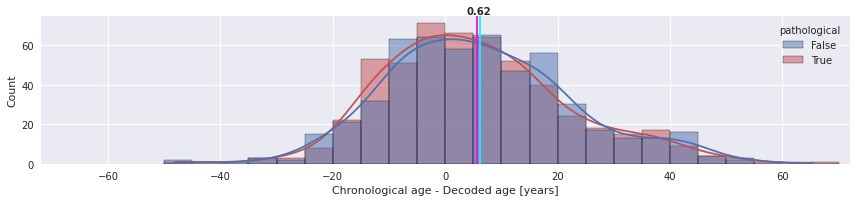

In [103]:
ax = plot_age_gap_hist(df)
ax.get_figure().tight_layout()
ax.set_title('')
s = 'recording' if not subject_wise else 'subject'
# ax.get_figure().savefig(
#     f'/home/jovyan/longitudinal_transition_{s}_age_gap.png', 
#     dpi=300, bbox_inches='tight')

In [3]:
# plot longitudinal pathological and non-pathological decoding results

In [4]:
bin_size = 2
max_age = 100

In [ ]:
for subject_wise in [True]:
    for longitudinal in ['non_pathological', 'pathological']:
        if longitudinal == 'non_pathological':
            hist_max_count = 2200 if not subject_wise else 250
        elif longitudinal == 'pathological':
            hist_max_count = 2200 if not subject_wise else 600

        df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
        # --- hack
        with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
            ds = pickle.load(f)
        df['subject'] = 5*ds.description['subject'].to_list()
        # ---
        if subject_wise:
            df = df.groupby(['subject', 'pathological'], as_index=False).mean()

        ax_arr = plot_heatmaps(df, bin_size, max_age, hist_max_count)
        s = 'recording' if not subject_wise else 'subject'
        # ax_arr.get_figure().savefig(
        #     f'/home/jovyan/longitudinal_{longitudinal}_chronological_vs_predicted_{s}_age.png',
        #     dpi=300, bbox_inches='tight')

In [476]:
# TODO: 
# fix age_clf
# compute p values for permutation test
# re-do age source figure
# get age benchmark going

In [477]:
base_dir = '/home/jovyan/experiments'
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages
# exp = '2022-10-08T08:04:26.625918'  # TCN, matched patho and non-patho dist in all ages
# exp = ''  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
exp_dir = os.path.join(base_dir, exp)

In [478]:
configs = read_result(exp_dir, 'config')

In [479]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,squash_outs,standardize_data,standardize_targets,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-08T08:06:12.236005,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
1,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-08T08:06:12.236005,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,1,6000,decode_age
2,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-08T08:04:26.625918,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,2,6000,decode_age
3,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-08T08:04:26.625918,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,3,6000,decode_age
4,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-08T08:04:26.625918,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,4,6000,decode_age


In [480]:
configs[['model_name', 'target_name', 'valid_set_i', 'min_age']]

,model_name,target_name,valid_set_i,min_age
0,tcn,age,0,-1
1,tcn,age,1,-1
2,tcn,age,2,-1
3,tcn,age,3,-1
4,tcn,age,4,-1


In [481]:
scores = read_result(exp_dir, 'score')

In [482]:
scores

,train,valid,valid_not_normal,seed,valid_set_i
mae,2.553754,8.446895e+00,11.978411,20220429,0
mape,inf,1.920270e-01,0.300585,20220429,0
mdae,1.485932,6.706233e+00,10.334003,20220429,0
mdape,0.034468,1.629842e-01,0.205942,20220429,0
r2,0.933751,5.732781e-01,0.198677,20220429,0
mae,2.411586,7.342611e+00,10.330671,20220429,1
mape,inf,1.907598e-01,0.247319,20220429,1
mdae,1.444265,5.481782e+00,8.839514,20220429,1
mdape,0.031356,1.161684e-01,0.172991,20220429,1
r2,0.940129,6.487458e-01,0.227703,20220429,1


In [483]:
scores.loc['mae'].groupby('seed').mean()

,train,valid,valid_not_normal,valid_set_i
seed,,,,
20220429,2.424612,7.626285,10.941746,2.0


In [484]:
scores.loc['mdae'].groupby('seed').mean()

,train,valid,valid_not_normal,valid_set_i
seed,,,,
20220429,1.487578,5.903486,8.793505,2.0


In [485]:
scores.loc['mape'].groupby('seed').mean()

,train,valid,valid_not_normal,valid_set_i
seed,,,,
20220429,NaN,1.518222e+06,NaN,2.0


In [486]:
scores.loc['mdape'].groupby('seed').mean()

,train,valid,valid_not_normal,valid_set_i
seed,,,,
20220429,0.032436,0.12922,0.180825,2.0


In [487]:
scores.loc['r2'].groupby('seed').mean()

,train,valid,valid_not_normal,valid_set_i
seed,,,,
20220429,0.940904,0.604138,0.225828,2.0


In [488]:
histories = read_result(exp_dir, 'history')

Text(0.5, 1.0, 'Deep4, lr=0.005')

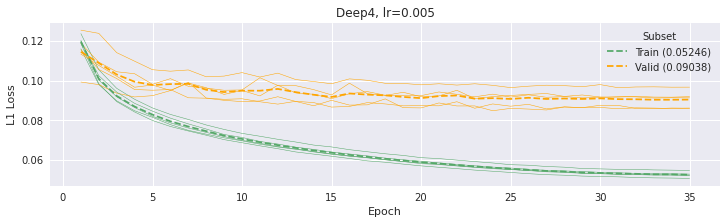

In [489]:
ax = plot_learning_curves([g for n, g in histories.groupby(['seed', 'valid_set_i'])], 'L1 Loss')
# ax.set_title(f'Deep4, lr=0.005')

In [491]:
preds = read_result(exp_dir, 'preds')

In [492]:
preds.shape

(1882, 19)

In [493]:
preds.groupby('subject').mean(numeric_only=True).shape

(1547, 14)

In [494]:
preds.groupby(['subject', 'pathological']).mean(numeric_only=True).shape

(1579, 13)

In [495]:
bin_size = 2
max_age = 100
hist_max_count = 220

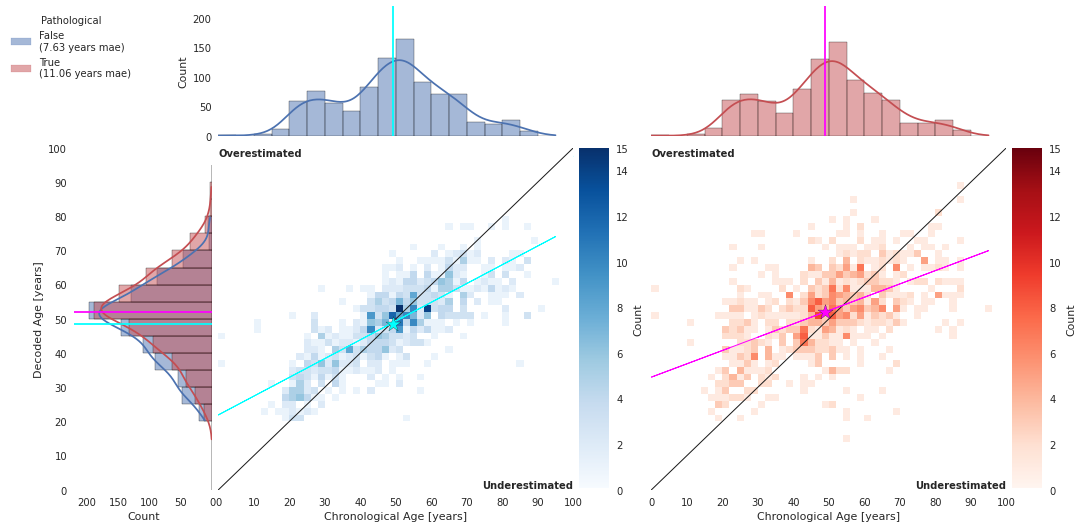

In [496]:
fig = plot_heatmaps(preds, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Subject-wise Pathological and Non-Pathological Brain Age Gap')

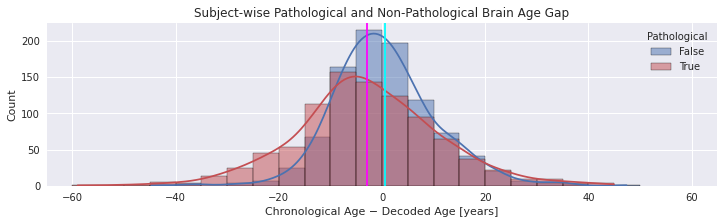

In [497]:
ax = plot_age_gap_hist(preds)
ax.set_title('Subject-wise Pathological and Non-Pathological Brain Age Gap')

In [498]:
n_repetitions = 100000

In [499]:
# Mittlere Differenz der Brain Age Gaps

Text(0.5, 1.0, 'Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

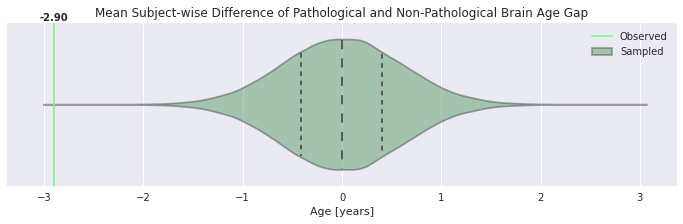

In [500]:
ax = plot_violin(
    *age_gap_diff_permutations(preds, n_repetitions, True), 
    'Age [years]',
)
ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

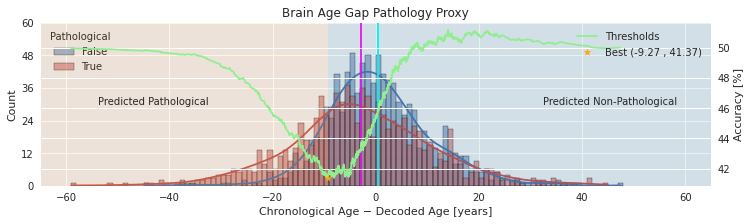

In [501]:
min_age, max_age = 0, 100
ax = plot_thresh_to_acc(preds[(preds.y_true >= min_age) & (preds.y_true <= max_age)] )
ax.set_title('Brain Age Gap Pathology Proxy')

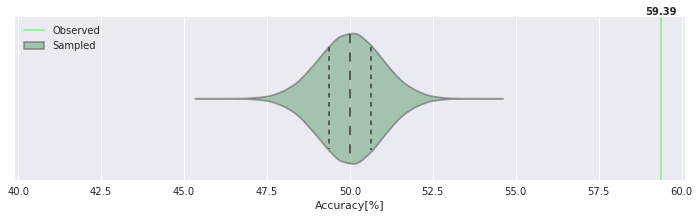

In [262]:
ax = plot_violin(
    *(accuracy_perumtations(preds, n_repetitions)),
    xlabel='Accuracy[%]',
    center_value=50,
)
# ax.get_figure().savefig('/home/jovyan/permutation_test_proxy.png', bbox_inches='tight', dpi=300)

__analyze preds with targets >= 18 years -> improvement?__

In [28]:
preds = preds[preds.y_true >= 18]

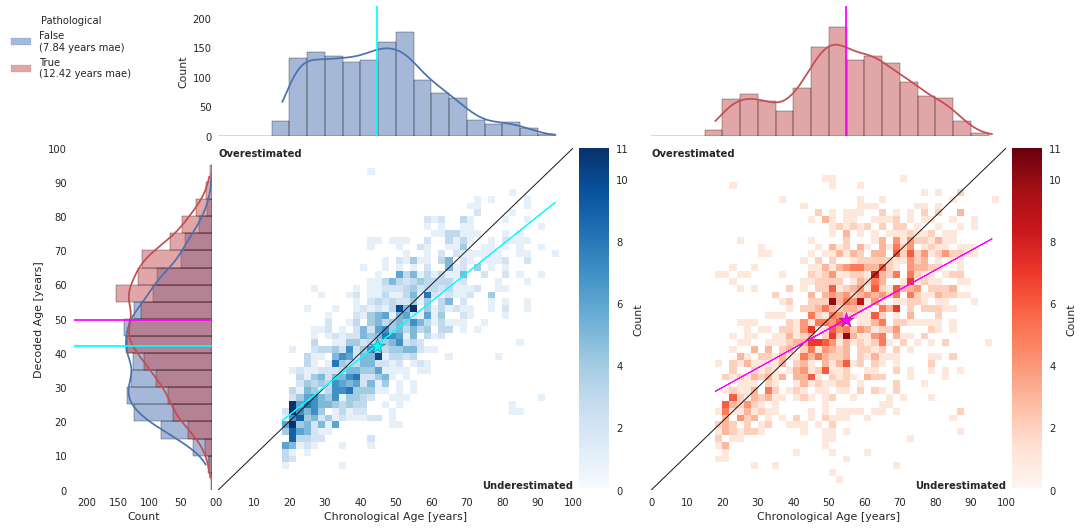

In [29]:
fig = plot_heatmaps(preds, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Subject-wise Pathological and Non-Pathological Brain Age Gap')

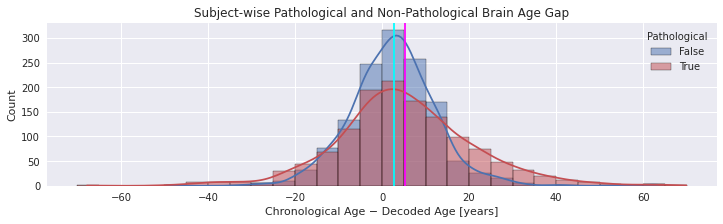

In [30]:
ax = plot_age_gap_hist(preds)
ax.set_title('Subject-wise Pathological and Non-Pathological Brain Age Gap')

Text(0.5, 1.0, 'Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

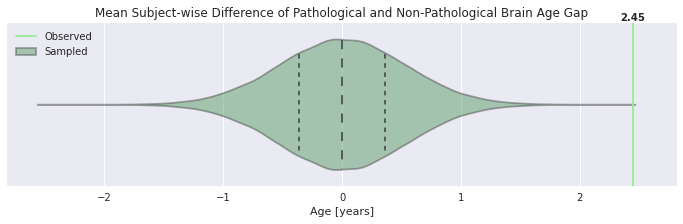

In [31]:
ax = plot_violin(
    *age_gap_diff_permutations(preds, n_repetitions, True), 
    'Age [years]',
)
ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

2015
7.835325027544705


Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

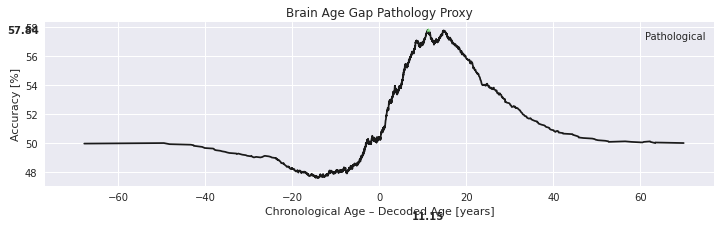

In [45]:
ax = plot_thresh_to_acc(preds)
ax.set_title('Brain Age Gap Pathology Proxy')

2015
7.835325027544705


Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

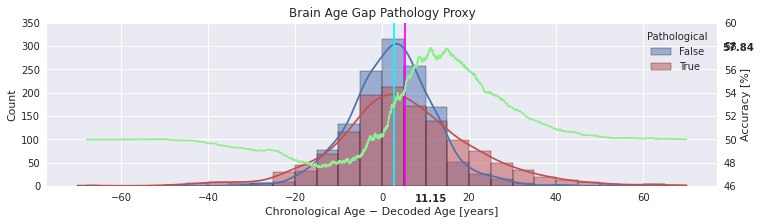

In [124]:
ax1 = plot_age_gap_hist(preds)
ax2 = ax1.twinx()
ax1.set_yticks(ax1.get_yticks())
ax2 = plot_thresh_to_acc(preds, ax=ax2)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax2.grid(None)
ax2.legend()
ax1.set_title('Brain Age Gap Pathology Proxy')
#ax1.set_xlabel('Chronological Age – Decoded Age [years]')
# ax2.axhline(50, linestyle='-', c='k', linewidth=1)

In [412]:
ages = [0, 18, 30, 60, 80, 100]

In [426]:
age_limits = [(ages[i], ages[j]) for i in range(len(ages)-1) for j in range(i+1, len(ages))]

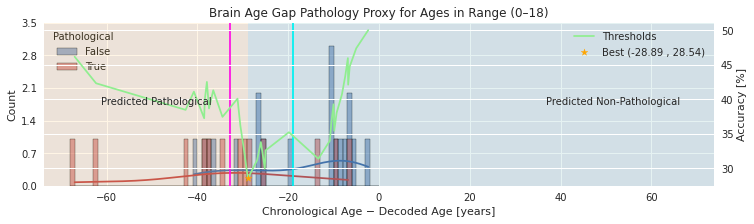

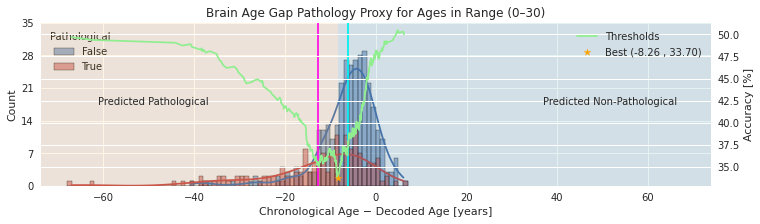

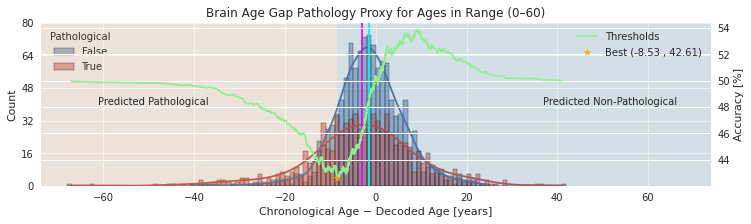

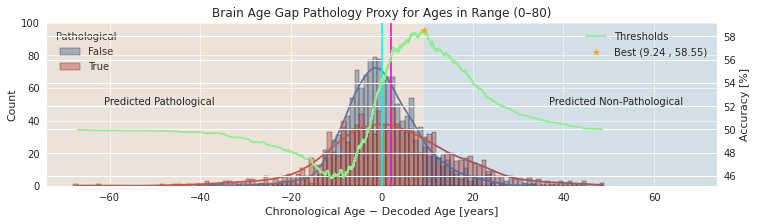

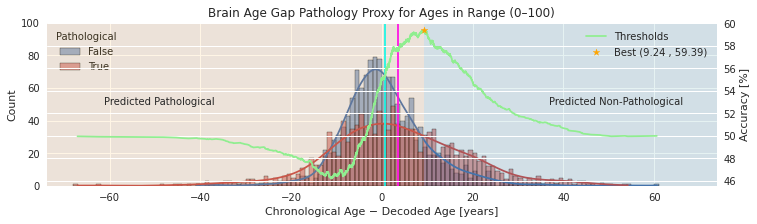

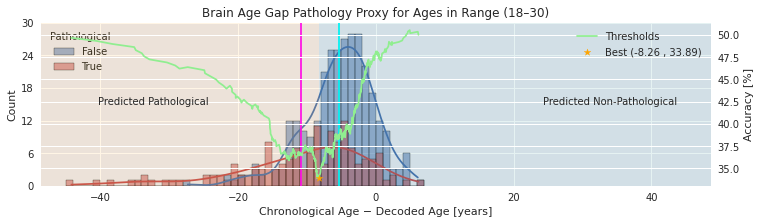

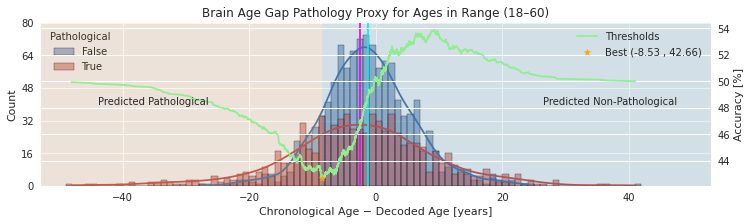

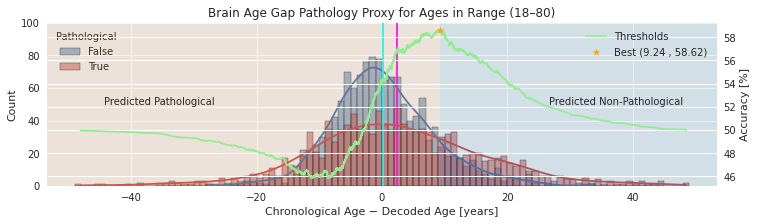

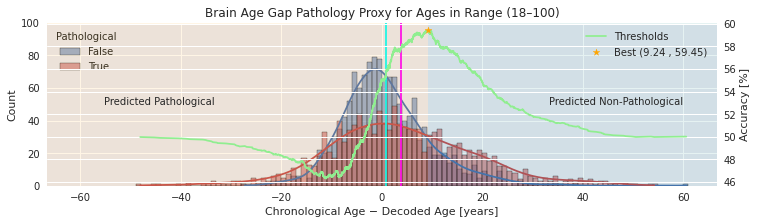

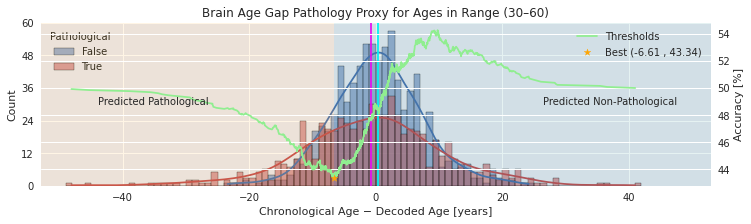

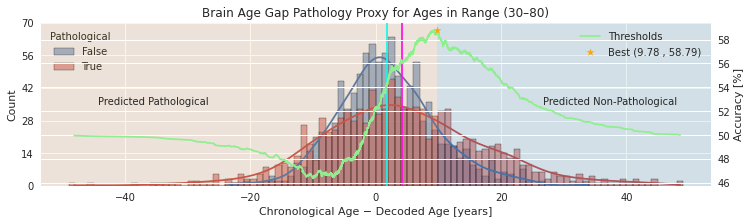

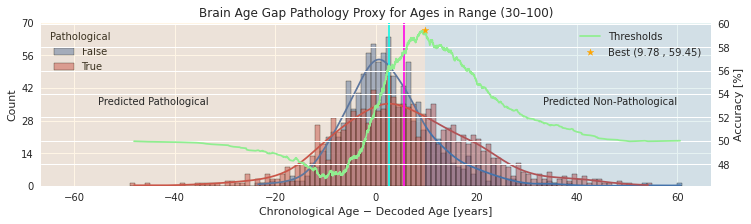

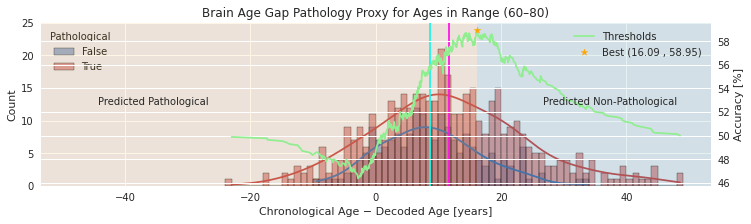

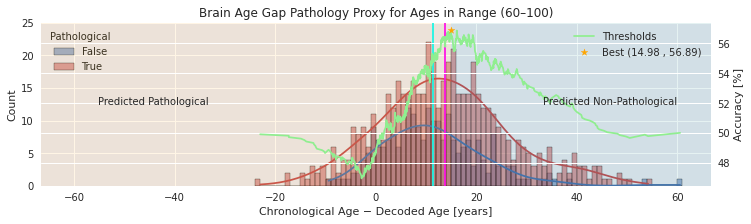

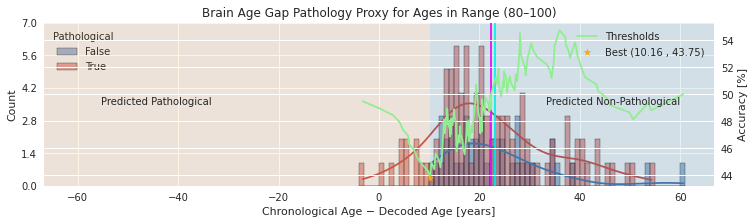

In [427]:
for min_age, max_age in age_limits:
    ax2 = plot_thresh_to_acc(preds[(preds.y_true >= min_age) & (preds.y_true < max_age)])
    ax2.set_title(ax2.get_title() + f' for Ages in Range ({min_age}–{max_age})')

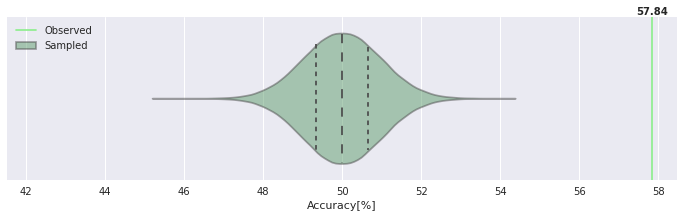

In [33]:
ax = plot_violin(
    *(accuracy_perumtations(preds, n_repetitions)),
    xlabel='Accuracy[%]',
    center_value=50,
)
# ax.get_figure().savefig('/home/jovyan/permutation_test_proxy.png', bbox_inches='tight', dpi=300)